# <b> Лабораторна робота №4
"Метод k найближчих сусідів"\
Виконала: Челюскіна Юлія КМ-21 (2-га підгрупа)

---

## Formulas

In [13]:
import numpy as np
from scipy.spatial.distance import cdist

def get_prediction_strength(k, train_centroids, x_test, test_labels):
    '''
    Обчислює Prediction Strength для кластеризації з k кластерами.

    Parameters
    ----------
    k : int
        Кількість кластерів
    train_centroids : np.array
        Центроїди, отримані на тренувальній частині
    x_test : np.array
        Тестові зразки
    test_labels : np.array
        Кластерні мітки, отримані на тестових даних

    Returns
    -------
    prediction_strength : float
        Prediction Strength значення
    '''

    x_test = np.asarray(x_test, dtype=float)
    n_test = len(x_test)
    D = np.zeros((n_test, n_test))

    # Призначаємо кожному зразку тесту найближчий центроїд з тренувального набору
    closest_train_labels = np.argmin(cdist(x_test, train_centroids), axis=1)

    # Створюємо матрицю схожості: 1 якщо обидва зразки належать до одного кластеру
    for i in range(n_test):
        for j in range(i + 1, n_test):
            if test_labels[i] == test_labels[j]:
                if closest_train_labels[i] == closest_train_labels[j]:
                    D[i, j] = 1.0
                    D[j, i] = 1.0

    # Обчислюємо prediction strength як мінімальне середнє значення по кожному кластеру
    min_strength = 1.0
    for cluster_id in range(k):
        indices = np.where(test_labels == cluster_id)[0]
        n = len(indices)
        if n > 1:
            count = 0
            for i in range(n):
                for j in range(i + 1, n):
                    count += D[indices[i], indices[j]]
            possible_pairs = n * (n - 1) / 2
            strength = count / possible_pairs
            if strength < min_strength:
                min_strength = strength

    return min_strength

In [14]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

def evaluate_clustering(model, model_name, X, y, feature_names=None):
    model.fit(X)
    labels = model.labels_

    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(X.shape[1])]

    # Центри кластерів
    print(f"[{model_name}] Координати центрів кластерів:")
    centers_df = pd.DataFrame(model.cluster_centers_, columns=feature_names)
    print(centers_df.round(2))


    # PCA + візуалізація
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    centers_reduced = pca.transform(model.cluster_centers_)
    print(f"Silhouette Score: {silhouette_score(X, labels):.4f}")
    print(f"Adjusted Rand Score: {adjusted_rand_score(y, labels):.4f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.scatter(centers_reduced[:, 0], centers_reduced[:, 1], c='red', marker='X', s=200, label='Центри')
    plt.legend()
    plt.title(f"{model_name}")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.show()

def evaluate_clustering_a(model, model_name, X,y, feature_names=None):
    model.fit(X)
    labels = model.labels_

    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(X.shape[1])]

    # PCA + візуалізація
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    
    print(f"Silhouette Score: {silhouette_score(X, labels):.4f}")
    print(f"Adjusted Rand Score: {adjusted_rand_score(y, labels):.4f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.legend()
    plt.title(f"{model_name}")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.show()



def plot_clustering_metrics(X,y, method = 'random'):
    k_range = range(2, 15)
    inertia = []
    silhouette_scores = []
    ari_scores = []

    # Обчислюємо інерцію та коефіцієнт силуету для кожного k
    for k in k_range:
        kmeans = KMeans(n_clusters=k, init=method, random_state=42)
        labels = kmeans.fit_predict(X)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, labels))
        ari_scores.append(adjusted_rand_score(y, labels))

    # train/test split
    X_train, X_test = train_test_split(X, test_size=0.2, shuffle=True, random_state=42)
    # running the clustering 
    strengths = []
    for k in k_range:
        model_train = KMeans(n_clusters=k, init=method, random_state=42).fit(X_train)
        model_test = KMeans(n_clusters=k, init=method, random_state=42).fit(X_test)
        
        pred_str = get_prediction_strength(k, model_train.cluster_centers_, X_test, model_test.labels_)
        strengths.append(pred_str)

        

    # Побудова графіків
    fig, axs = plt.subplots(1, 4, figsize=(18, 5))
    # Elbow Method
    axs[0].plot(k_range, inertia, 'bo-')
    axs[0].set_xlabel('Кількість кластерів (k)')
    axs[0].set_ylabel('Inertia')
    axs[0].set_title('Elbow Method')

    # Silhouette Method
    axs[1].plot(k_range, silhouette_scores, 'go-')
    axs[1].set_xlabel('Кількість кластерів (k)')
    axs[1].set_ylabel('Середній коефіцієнт силуету')
    axs[1].set_title('Average Silhouette Method')

    axs[2].plot(k_range, strengths, '-o', color='black')
    axs[2].axhline(y=0.8, c='red')
    axs[2].set(title='Determining the optimal number of clusters', 
        xlabel='Кількість кластерів (k)', 
        ylabel='prediction strength')

    axs[3].plot(k_range, ari_scores, '-o')
    axs[3].set_xlabel('Кількість кластерів (k)')
    axs[3].set_ylabel('Adjusted Rand Index ')
    axs[3].set_title('Adjusted Rand Index ')
    for ax in axs:
        ax.grid(True)
    plt.tight_layout()
    plt.show()


In [15]:
from itertools import combinations
def find_best_feature_removal_combinations(X, n_clusters=3, max_remove=2, random_state=42, method = 'random'):
    base_kmeans = KMeans(n_clusters=n_clusters, init=method, random_state=random_state, n_init=10)
    base_labels = base_kmeans.fit_predict(X)
    base_score = silhouette_score(X, base_labels)
    print(f"Базовий Silhouette Score: {base_score:.4f}\n")

    results = []

    features = X.columns
    for r in range(1, max_remove + 1):
        for combo in combinations(features, r):
            X_reduced = X.drop(columns=list(combo))
            kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10, init=method)
            labels = kmeans.fit_predict(X_reduced)
            score = silhouette_score(X_reduced, labels)
            score_diff = score - base_score
            results.append({
                'removed_features': combo,
                'silhouette_score': score,
                'delta': score_diff
            })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='silhouette_score', ascending=False)

    print("Топ-2 комбінацій, які покращують кластеризацію:")
    for i, row in results_df.head(2).iterrows():
        print(f"- Видалити {row['removed_features']}: Score = {row['silhouette_score']:.4f}, Δ = {row['delta']:+.4f}")

    return results_df

## Початкові дані (1-3)

In [16]:
import pandas as pd
df  = pd.read_csv("ЛР5-пгр2.csv", delimiter=";")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [17]:
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

Number of rows: 1599
Number of columns: 12


In [18]:
from clustergram import Clustergram
import urbangrammar_graphics as ugg
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

#sns.set(style='whitegrid')
#g = sns.pairplot(df, hue="quality", palette='tab10')

In [19]:
y = df['quality']
X = df.drop(columns=['quality'])
print("Train class balance (percent):", y.value_counts(normalize=True) * 100)

Train class balance (percent): quality
5    42.589118
6    39.899937
7    12.445278
4     3.314572
8     1.125704
3     0.625391
Name: proportion, dtype: float64


In [20]:
X.columns.to_list()

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

## Step 1

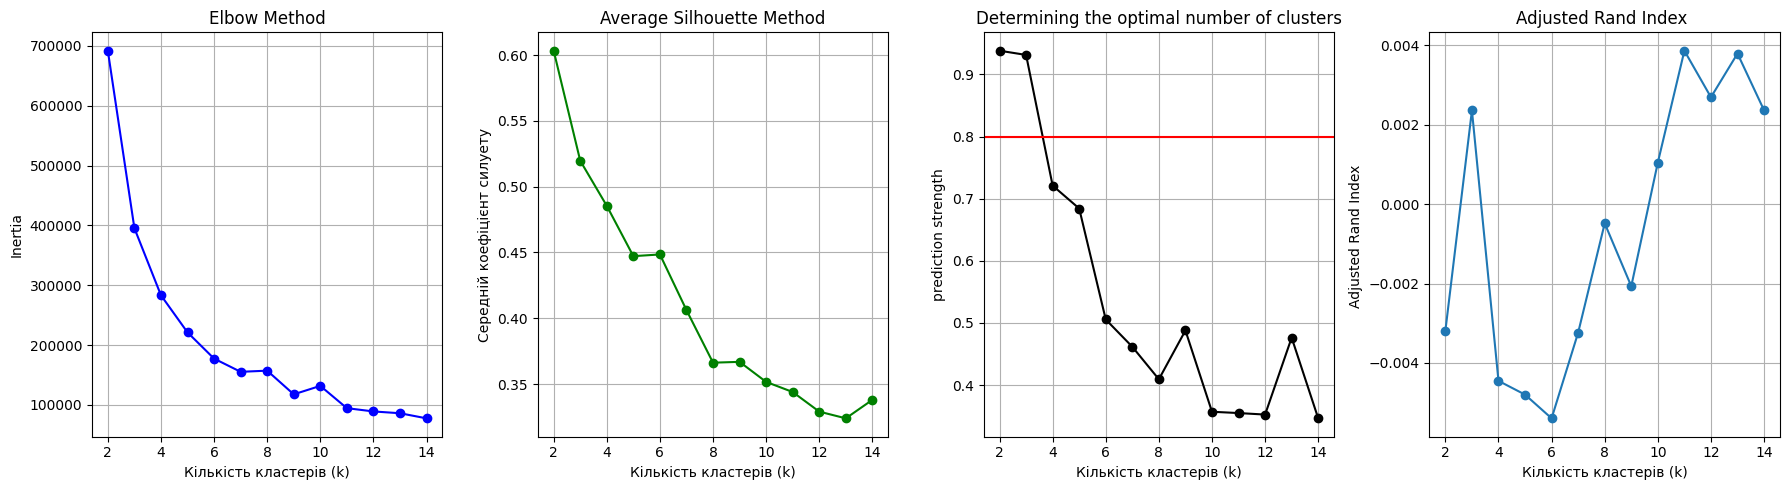

In [21]:
plot_clustering_metrics(X,y)

[KMeans з початковими даними] Координати центрів кластерів:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0           8.47              0.52         0.27            2.36       0.08   
1           7.89              0.57         0.28            3.23       0.09   
2           8.29              0.52         0.27            2.50       0.09   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 9.00                 22.39      1.0  3.31       0.65   
1                26.15                108.51      1.0  3.29       0.65   
2                21.57                 54.89      1.0  3.32       0.68   

   alcohol  
0    10.58  
1    10.01  
2    10.38  
Silhouette Score: 0.5197
Adjusted Rand Score: 0.0024


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


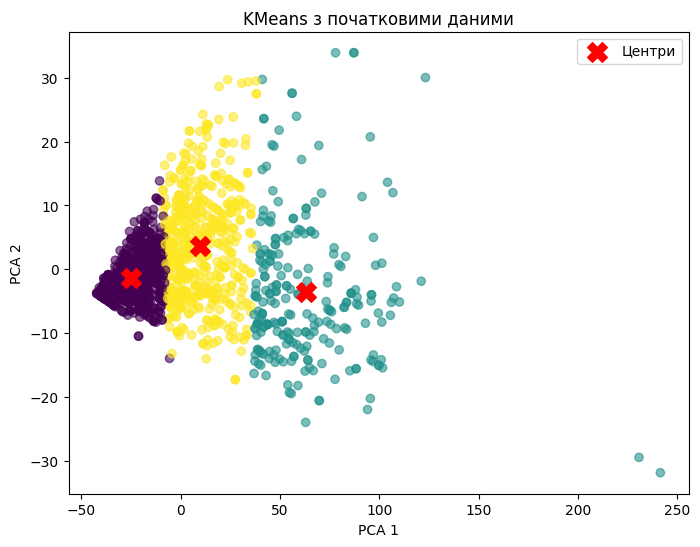

In [22]:
kmeans = KMeans(n_clusters=3, n_init='auto', init='random', random_state=1)
evaluate_clustering(kmeans, "KMeans з початковими даними", X, y,feature_names=X.columns)

## Step 2

In [23]:
from sklearn.preprocessing import StandardScaler
scaler =StandardScaler()

Xx =scaler.fit(X)
Xx =Xx.transform(X)

# Convert to pandas Dataframe
Xx =pd.DataFrame(Xx,columns=X.columns)

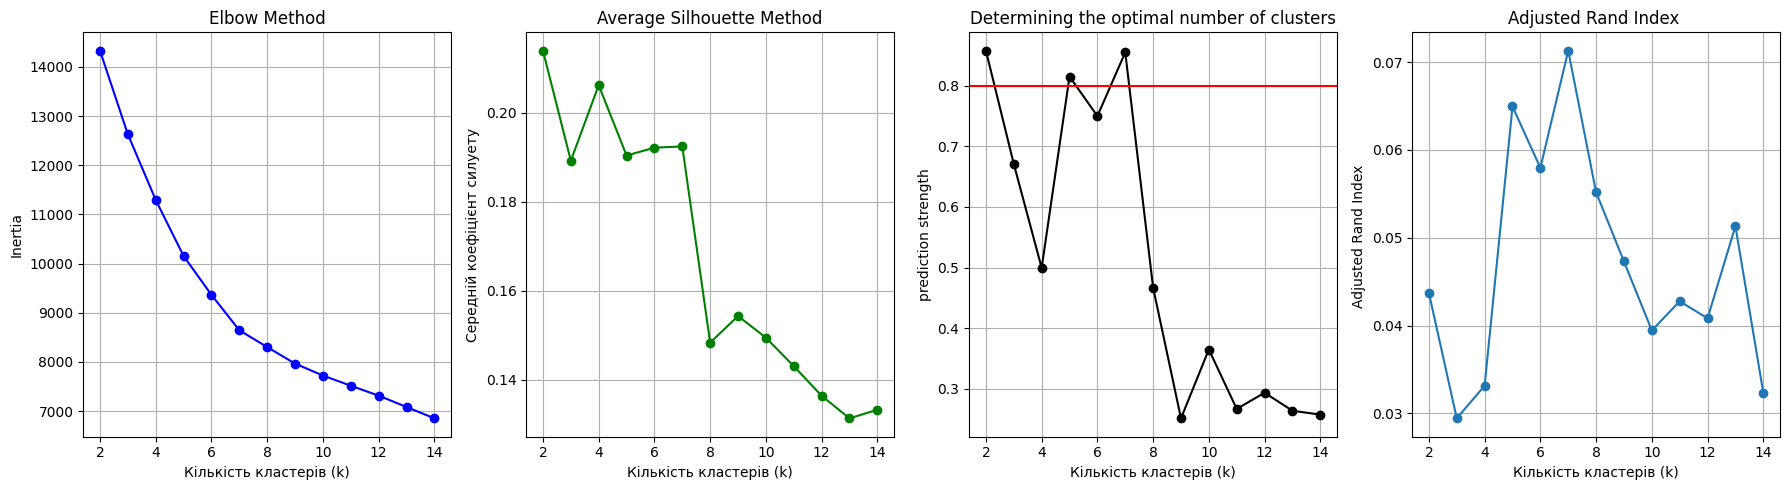

In [24]:
plot_clustering_metrics(Xx, y)

[KMeans з даними після нормалізації] Координати центрів кластерів:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0           1.06             -0.74         1.02            0.06      -0.06   
1          -0.65              0.46        -0.76           -0.23      -0.18   
2           0.07              0.01         1.10           -0.41       5.52   
3          -0.09              0.04         0.10            0.40      -0.02   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                -0.51                 -0.54     0.45 -0.70       0.35   
1                -0.23                 -0.35    -0.44  0.61      -0.28   
2                -0.09                  0.50     0.18 -1.67       3.62   
3                 1.08                  1.31     0.28 -0.16      -0.18   

   alcohol  
0     0.37  
1     0.06  
2    -0.89  
3    -0.50  
Silhouette Score: 0.2053
Adjusted Rand Score: 0.0321


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


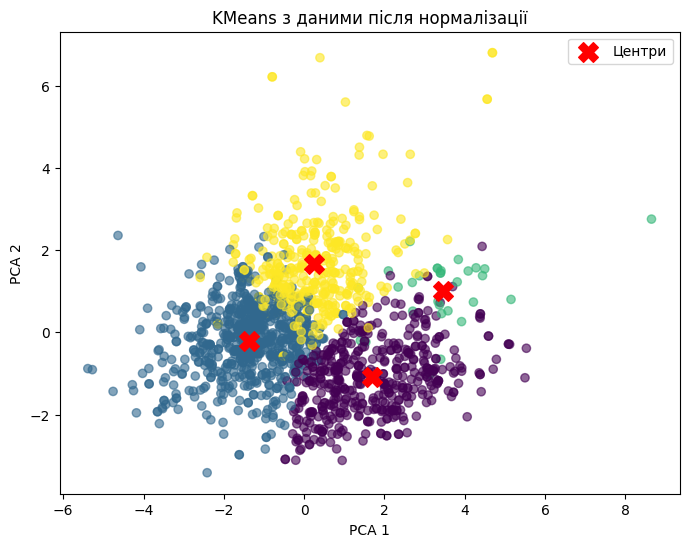

In [25]:
kmeans = KMeans(n_clusters=4, n_init='auto', init='random', random_state=1)
evaluate_clustering(kmeans, "KMeans з даними після нормалізації", Xx, y, feature_names=X.columns)

## Step 3

In [26]:
#find_best_feature_removal_combinations(Xx, 4, 7)

In [27]:
#find_best_feature_removal_combinations(Xx, 4, 7, method='k-means++')

Модель для 4 кластерів

Для рандом:
- Базовий Silhouette Score: 0.2062
- Видалити ('fixed acidity', 'volatile acidity', 'citric acid', 'density', 'pH', 'sulphates', 'alcohol'): Score = 0.4213, Δ = +0.2151

Для k-means++:
- Базовий Silhouette Score: 0.1716
- Видалити ('fixed acidity', 'volatile acidity', 'citric acid', 'density', 'pH', 'sulphates', 'alcohol'): Score = 0.4213, Δ = +0.2496

Ознаки, які залишились після видалення: ['residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide']


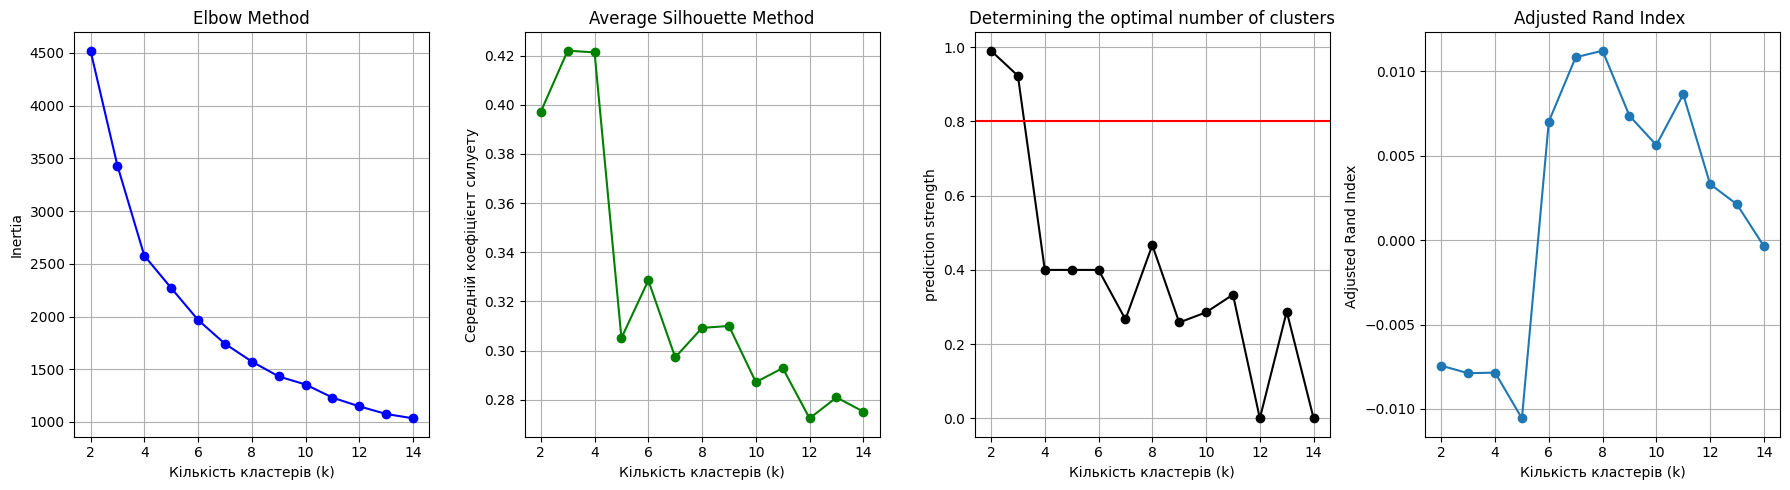

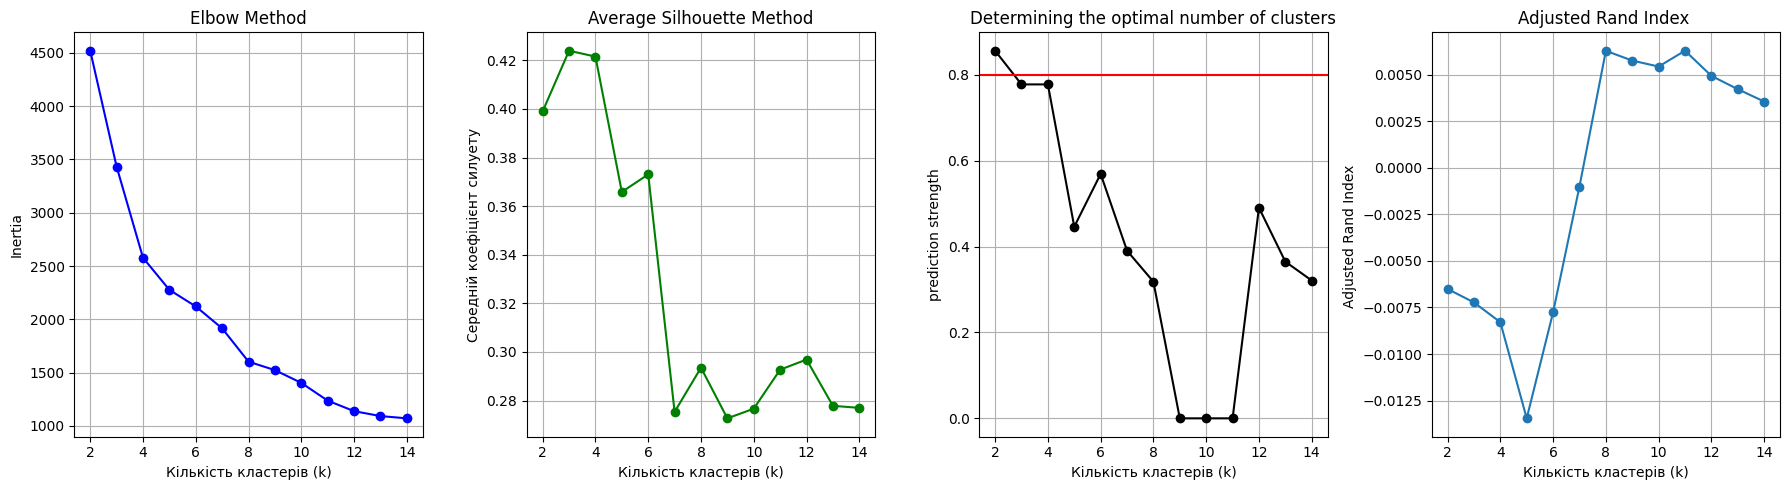

In [28]:
X_filtered = Xx.drop(columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'density', 'pH', 'sulphates', 'alcohol'])

print("Ознаки, які залишились після видалення:", X_filtered.columns.to_list())

plot_clustering_metrics(X_filtered, y)
plot_clustering_metrics(X_filtered, y, 'k-means++')

[KMeans з видаленими атрибутами] Координати центрів кластерів:
   residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide
0           -0.38       5.98                -0.17                  0.11
1            0.25      -0.10                 1.05                  1.05
2           -0.12      -0.12                -0.55                 -0.56
Silhouette Score: 0.4219
Adjusted Rand Score: -0.0079


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


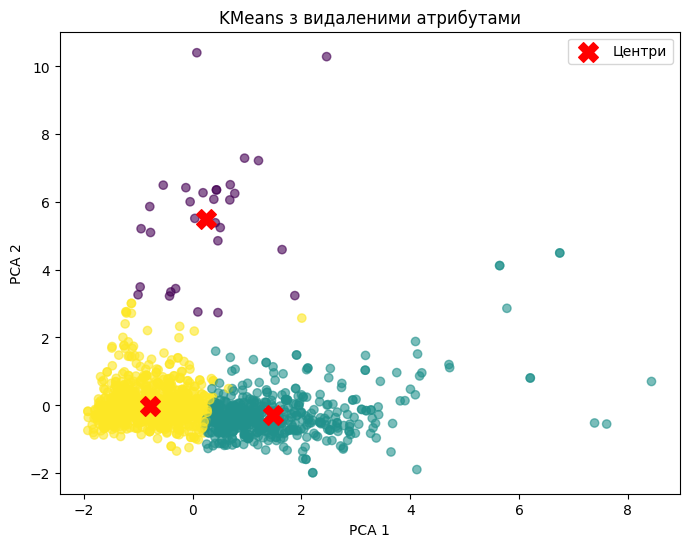

In [29]:
kmeans = KMeans(n_clusters=3, n_init='auto', init='random', random_state=1)
evaluate_clustering(kmeans, "KMeans з видаленими атрибутами", X_filtered, y,feature_names=X_filtered.columns)

[KMeans з видаленими атрибутами k-means++] Координати центрів кластерів:
   residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide
0           -0.38       5.98                -0.17                  0.11
1           -0.12      -0.11                -0.58                 -0.59
2            4.11       0.21                 1.46                  1.58
3           -0.15      -0.15                 0.93                  0.92
Silhouette Score: 0.4208
Adjusted Rand Score: -0.0073


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


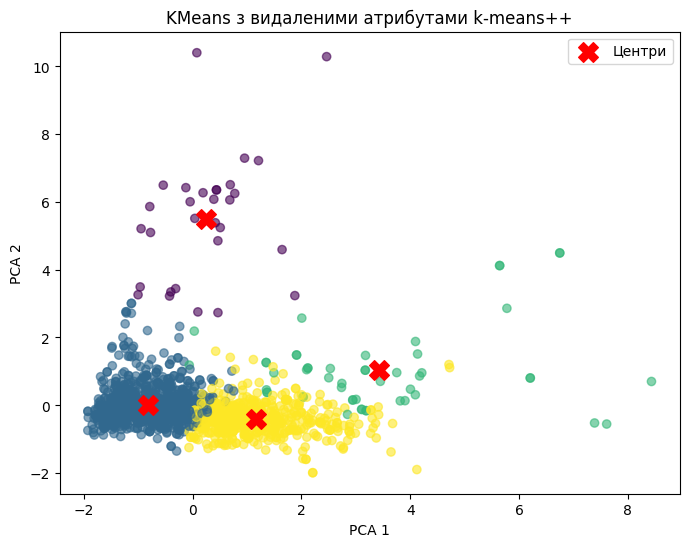

In [30]:
kmeans = KMeans(n_clusters=4, n_init='auto', init='k-means++', random_state=1)
evaluate_clustering(kmeans, "KMeans з видаленими атрибутами k-means++", X_filtered, y,feature_names=X_filtered.columns)

[KMeans k-means++] Координати центрів кластерів:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0           8.49              0.52         0.27            2.37       0.08   
1           8.25              0.52         0.27            2.50       0.09   
2           7.87              0.57         0.27            3.23       0.09   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 9.27                 23.26      1.0  3.31       0.65   
1                22.23                 56.24      1.0  3.32       0.68   
2                26.04                108.63      1.0  3.29       0.65   

   alcohol  
0    10.58  
1    10.35  
2    10.01  
Silhouette Score: 0.5220
Adjusted Rand Score: -0.0001


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


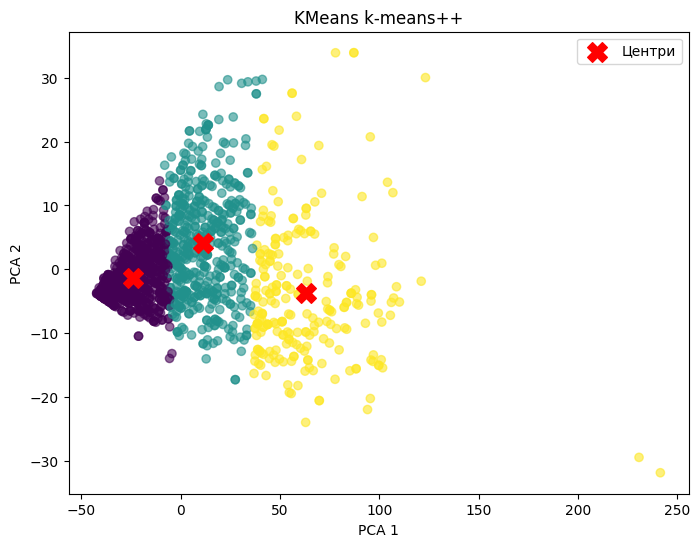

In [33]:
kmeans = KMeans(n_clusters=3, n_init='auto', init='k-means++', random_state=1)
evaluate_clustering(kmeans, "KMeans k-means++", X, y,feature_names=X.columns)

## Ієрархічна 

Silhouette Score: 0.4740
Adjusted Rand Score: 0.0087


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14692\2704388327.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


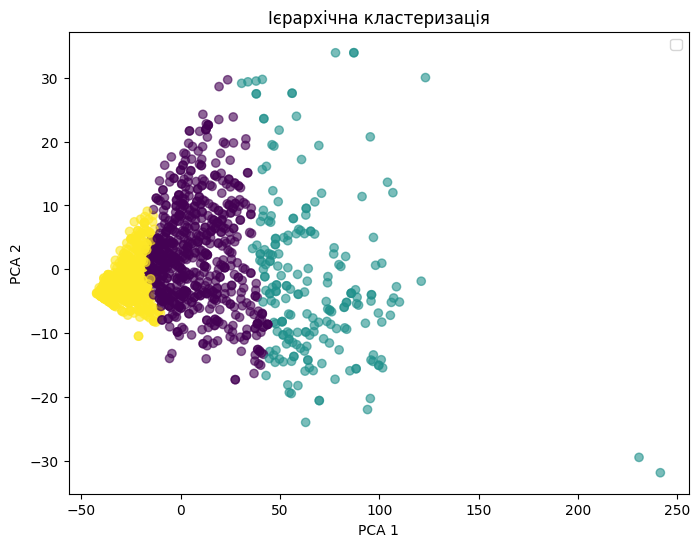

Silhouette Score: 0.1714
Adjusted Rand Score: 0.0479


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14692\2704388327.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


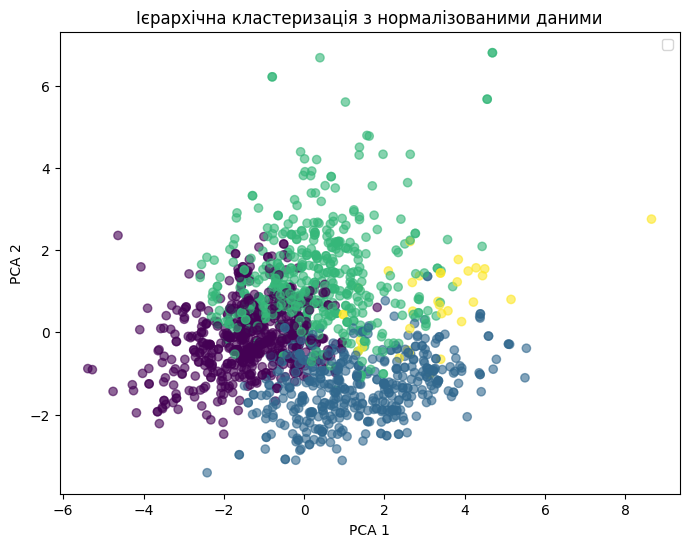

Silhouette Score: 0.4015
Adjusted Rand Score: -0.0142


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14692\2704388327.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


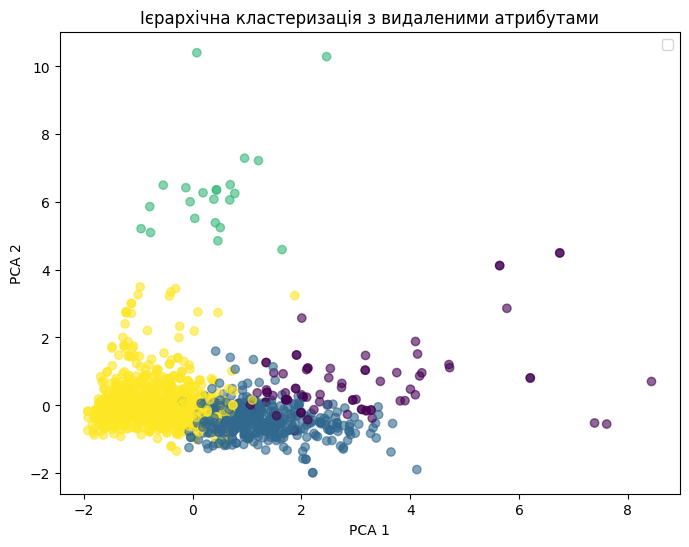

In [31]:
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
model = AgglomerativeClustering(n_clusters=4)
evaluate_clustering_a(AgglomerativeClustering(n_clusters=3), "Ієрархічна кластеризація", X, y, X.columns)
evaluate_clustering_a(model, "Ієрархічна кластеризація з нормалізованими даними", Xx, y, X.columns)
evaluate_clustering_a(model, "Ієрархічна кластеризація з видаленими атрибутами", X_filtered, y, X.columns)

## Початковий датасет

In [32]:
#find_best_feature_removal_combinations(X,3,7)

Базовий Silhouette Score: 0.5197

Топ-2 комбінацій, які покращують кластеризацію:
- Видалити ('fixed acidity', 'volatile acidity', 'citric acid', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol'): Score = 0.7535, Δ = +0.2338
- Видалити ('fixed acidity', 'volatile acidity', 'citric acid', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'alcohol'): Score = 0.7534, Δ = +0.2337


,removed_features,silhouette_score,delta
1545,"(fixed acidity, volatile acidity, citric acid,...",0.753506,0.233762
1544,"(fixed acidity, volatile acidity, citric acid,...",0.753440,0.233696
1664,"(fixed acidity, citric acid, free sulfur dioxi...",0.748346,0.228602
1608,"(fixed acidity, volatile acidity, free sulfur ...",0.744991,0.225246
1523,"(fixed acidity, volatile acidity, citric acid,...",0.738006,0.218261
...,...,...,...
1167,"(fixed acidity, citric acid, residual sugar, f...",0.296790,-0.222954
1672,"(fixed acidity, residual sugar, chlorides, fre...",0.293103,-0.226642
1684,"(fixed acidity, residual sugar, free sulfur di...",0.284149,-0.235596
1244,"(fixed acidity, residual sugar, free sulfur di...",0.284127,-0.235618


Ознаки, які залишились після видалення: ['residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide']


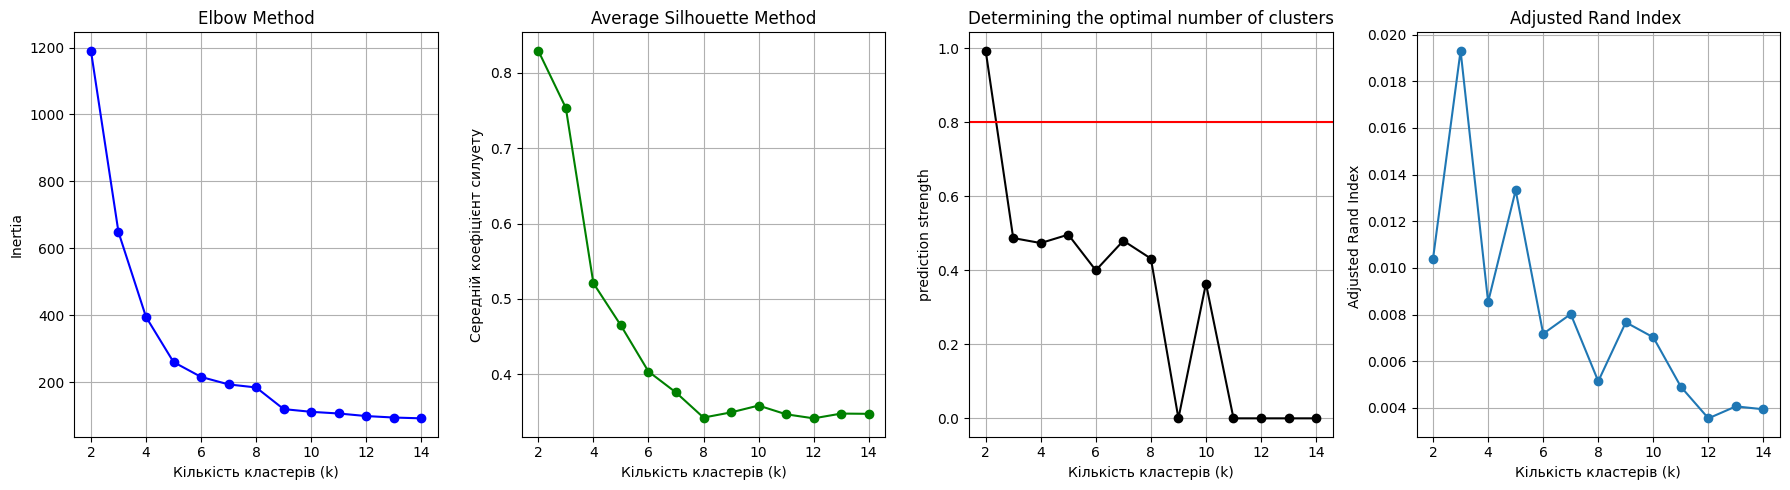

In [35]:
X_best = X.drop(columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol'])
print("Ознаки, які залишились після видалення:", X_filtered.columns.to_list())
plot_clustering_metrics(X_best, y)


[KMeans початковий з видаленими атрибутами] Координати центрів кластерів:
   residual sugar  chlorides  density    pH
0            2.17       0.09      1.0  3.31
1           10.43       0.10      1.0  3.26
2            4.88       0.09      1.0  3.28
Silhouette Score: 0.7535
Adjusted Rand Score: 0.0193


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


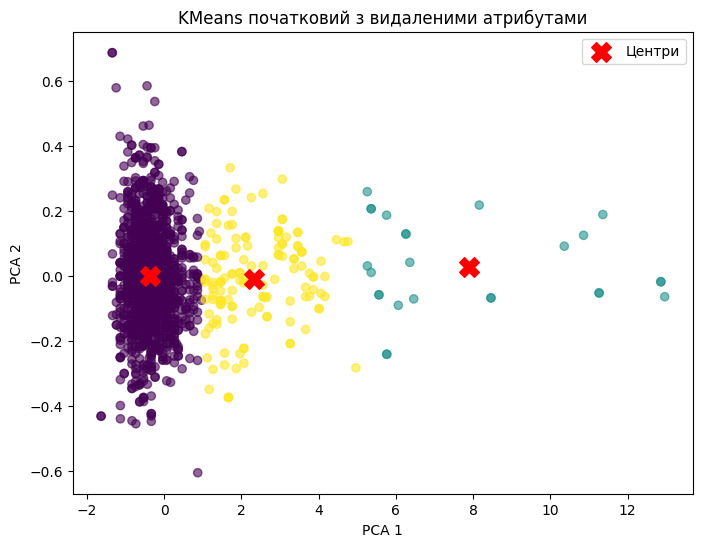

[KMeans початковий з видаленими атрибутами] Координати центрів кластерів:
   residual sugar  chlorides  density    pH
0            2.17       0.09      1.0  3.31
1           10.43       0.10      1.0  3.26
2            4.88       0.09      1.0  3.28
Silhouette Score: 0.7535
Adjusted Rand Score: 0.0193


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


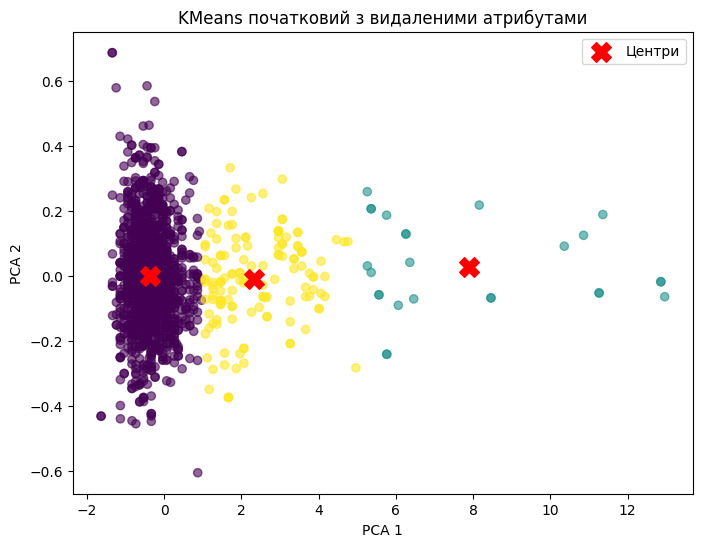

Silhouette Score: 0.8115
Adjusted Rand Score: 0.0112


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14692\2704388327.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


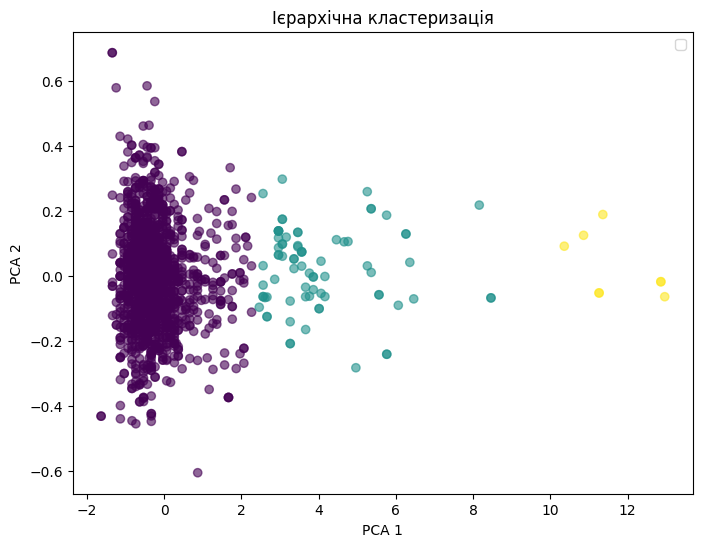

In [36]:
evaluate_clustering(KMeans(n_clusters=3, n_init='auto', init='random', random_state=1), "KMeans початковий з видаленими атрибутами", X_best, y,feature_names=X_best.columns)
evaluate_clustering(KMeans(n_clusters=3, n_init='auto', init='k-means++', random_state=1), "KMeans початковий з видаленими атрибутами", X_best, y,feature_names=X_best.columns)
evaluate_clustering_a(AgglomerativeClustering(n_clusters=3), "Ієрархічна кластеризація", X_best, y, X_best.columns)

[KMeans початковий з видаленими атрибутами] Координати центрів кластерів:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0           8.49              0.52         0.27            2.37       0.08   
1           8.25              0.52         0.27            2.50       0.09   
2           7.87              0.57         0.27            3.23       0.09   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 9.27                 23.26      1.0  3.31       0.65   
1                22.23                 56.24      1.0  3.32       0.68   
2                26.04                108.63      1.0  3.29       0.65   

   alcohol  
0    10.58  
1    10.35  
2    10.01  
Silhouette Score: 0.5220
Adjusted Rand Score: -0.0001


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


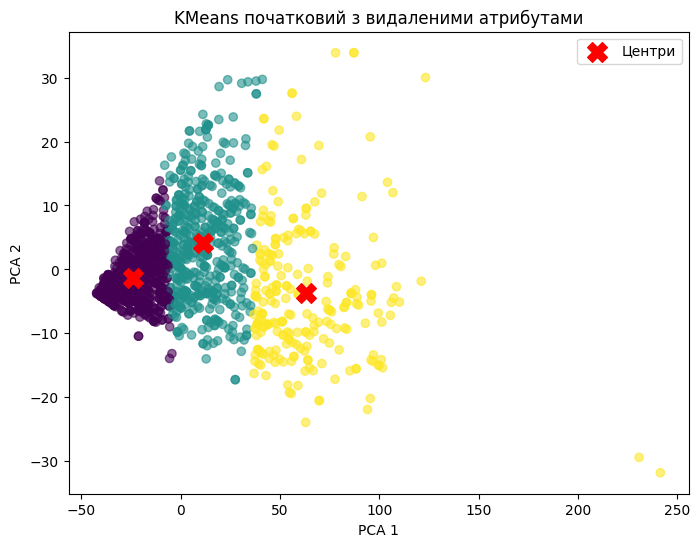

In [37]:
evaluate_clustering(KMeans(n_clusters=3, n_init='auto', init='k-means++', random_state=1), "KMeans початковий з видаленими атрибутами", X, y,feature_names=X.columns)